In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


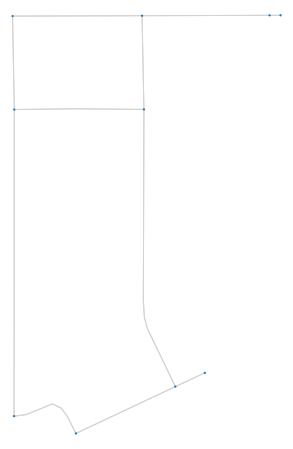

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/bca289655a38439e816fc22a9829b2f5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/bca289655a38439e816fc22a9829b2f5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 97 COLUMNS
At line 782 RHS
At line 875 BOUNDS
At line 975 ENDATA
Problem MODEL has 92 rows, 99 columns and 396 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 609.18 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fi

TwoMirCuts was tried 182 times and created 469 cuts of which 0 were active after adding rounds of cuts (0.121 seconds)
ZeroHalf was tried 182 times and created 113 cuts of which 0 were active after adding rounds of cuts (4.570 seconds)
ImplicationCuts was tried 82 times and created 4 cuts of which 0 were active after adding rounds of cuts (0.002 seconds)

Result - Optimal solution found

Objective value:                1144.30000000
Enumerated nodes:               28
Total iterations:               4169
Time (CPU seconds):             6.75
Time (Wallclock seconds):       11.57

Option for printingOptions changed from normal to all
Total time (CPU seconds):       6.76   (Wallclock seconds):       11.58



In [2]:

#Creating a bounding box
north, south, east, west = 43.146918,43.150018,-77.646432,-77.643836
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)




/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


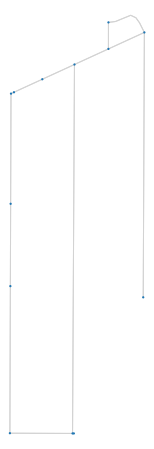

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/ec51f53c547c4624a8ec25bd53568ced-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/ec51f53c547c4624a8ec25bd53568ced-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 163 COLUMNS
At line 1364 RHS
At line 1523 BOUNDS
At line 1692 ENDATA
Problem MODEL has 158 rows, 168 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1241.05 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl

In [2]:
#FIRST AGAIN____
#Creating a bounding box
north, south, east, west = 43.142237,43.147200,-77.648127,-77.645767
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)





In [3]:
path1=pathlist

In [31]:
node_loc_duration = []
for i in range(data4.index.stop-1):
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{data4.loc[i, "Longitude"]},{data4.loc[i, "Latitude"]};{data4.loc[i+1, "Longitude"]},{data4.loc[i+1, "Latitude"]}?overview=false""")
    node_loc_duration.append(json.loads(r.content)["routes"][0]["duration"])

In [32]:
node_loc_duration

[31.9,
 0,
 32,
 5.2,
 2.8,
 66.1,
 5.6,
 0,
 2.3,
 0,
 11.5,
 0,
 17.7,
 0,
 9.9,
 0,
 13.8,
 0,
 0.2,
 0,
 4.4,
 0,
 9.6,
 0,
 2.8,
 10.1,
 0,
 12.1,
 0,
 8.5]

In [152]:
path1

[212673147.0,
 212624950,
 212624950.0,
 212673147,
 212765253,
 212765248,
 212787670,
 5842737587.0,
 5842737587.0,
 212787670,
 212787670.0,
 212719149,
 212719149.0,
 212719146,
 212719146.0,
 212679968,
 212679968.0,
 5842735673,
 5842735673.0,
 7202733160,
 7202733160.0,
 212668635,
 212668635.0,
 212765248,
 212765248.0,
 212765253,
 8038998601.0,
 8038998601.0,
 212765253,
 212765253.0,
 212673147]

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



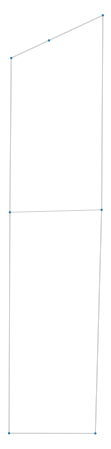

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/78a4b7cf52b849d5bcc1312918aef50c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/78a4b7cf52b849d5bcc1312918aef50c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 49 COLUMNS
At line 362 RHS
At line 407 BOUNDS
At line 456 ENDATA
Problem MODEL has 44 rows, 48 columns and 174 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 986.129 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 f

ck seconds):       0.77

Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.45   (Wallclock seconds):       0.79



In [35]:

#Creating a bounding box
north, south, east, west = 43.143614,43.149031,-77.642269,-77.640467 
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)



In [36]:
path2=pathlist

In [39]:
node_loc_duration2 = []
for i in range(data4.index.stop-1):
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{data4.loc[i, "Longitude"]},{data4.loc[i, "Latitude"]};{data4.loc[i+1, "Longitude"]},{data4.loc[i+1, "Latitude"]}?overview=false""")
    node_loc_duration2.append(json.loads(r.content)["routes"][0]["duration"])

In [40]:
node_loc_duration2

[30.2, 0, 4.3, 0, 3.1, 0, 34.5, 0, 42.1, 0, 17.8, 0, 26.6]

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



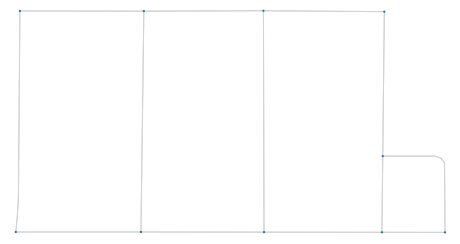

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/e9629729458c46a2be6082d9af6e0ff1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/e9629729458c46a2be6082d9af6e0ff1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 97 COLUMNS
At line 782 RHS
At line 875 BOUNDS
At line 975 ENDATA
Problem MODEL has 92 rows, 99 columns and 396 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1041.92 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 f

ibility pump after 0 iterations and 0 nodes (0.12 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0031I 7 added rows had average density of 4.8571429
Cbc0013I At root node, 7 cuts changed objective from 1042.7333 to 1056.28 in 4 passes
Cbc0014I Cut generator 0 (Probing) - 122 row cuts average 3.6 elements, 7 column cuts (7 active)  in 0.003 seconds - new frequency is 1
Cbc0014I Cut generator 1 (Gomory) - 18 row cuts average 12.1 elements, 0 column cuts (0 active)  in 0.001 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.002 seconds - new frequency is -100
Cbc0014I Cut generator 3 (Clique) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 4 (MixedIntegerRounding2) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 5 (FlowCover) - 2 row c

In [41]:

#Creating a bounding box
north, south, east, west = 43.142049,43.144241,-77.646089,-77.641239
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)




In [42]:
path3=pathlist

In [45]:
node_loc_duration3 = []
for i in range(data4.index.stop-1):
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{data4.loc[i, "Longitude"]},{data4.loc[i, "Latitude"]};{data4.loc[i+1, "Longitude"]},{data4.loc[i+1, "Latitude"]}?overview=false""")
    node_loc_duration3.append(json.loads(r.content)["routes"][0]["duration"])

In [46]:
node_loc_duration3

[17.2,
 0,
 9,
 0,
 10.1,
 0,
 6.8,
 10.8,
 0,
 9.1,
 0,
 11.3,
 0,
 23.6,
 0,
 20,
 0,
 19.6,
 0,
 19.7]

In [153]:
mainpath=path1+path2+path3

In [47]:
total=node_loc_duration+node_loc_duration2+node_loc_duration3

In [48]:
total

[31.9,
 0,
 32,
 5.2,
 2.8,
 66.1,
 5.6,
 0,
 2.3,
 0,
 11.5,
 0,
 17.7,
 0,
 9.9,
 0,
 13.8,
 0,
 0.2,
 0,
 4.4,
 0,
 9.6,
 0,
 2.8,
 10.1,
 0,
 12.1,
 0,
 8.5,
 30.2,
 0,
 4.3,
 0,
 3.1,
 0,
 34.5,
 0,
 42.1,
 0,
 17.8,
 0,
 26.6,
 17.2,
 0,
 9,
 0,
 10.1,
 0,
 6.8,
 10.8,
 0,
 9.1,
 0,
 11.3,
 0,
 23.6,
 0,
 20,
 0,
 19.6,
 0,
 19.7,
 30.2,
 0,
 4.3,
 0,
 3.1,
 0,
 34.5,
 0,
 42.1,
 0,
 17.8,
 0,
 26.6,
 17.2,
 0,
 9,
 0,
 10.1,
 0,
 6.8,
 10.8,
 0,
 9.1,
 0,
 11.3,
 0,
 23.6,
 0,
 20,
 0,
 19.6,
 0,
 19.7]

In [49]:
sum(total)

878.1000000000004

In [50]:
path1

[212624947.0, 212624944]

In [51]:
path2

[212650634.0,
 212765270,
 212765270.0,
 212765265,
 212765265.0,
 212765262,
 212765262.0,
 212650636,
 212650636.0,
 212624944,
 212624944.0,
 212624940,
 212624940.0,
 212650634]

In [52]:
path3

[212624944.0,
 7199136342,
 7199136342.0,
 212787665,
 212787665.0,
 7199136346,
 7199136346.0,
 212787665,
 212787668.0,
 212787668.0,
 212624740,
 212624740.0,
 212673089,
 212673089.0,
 212624950,
 212624950.0,
 212624737,
 212624737.0,
 212624947,
 212624947.0,
 212624944]

In [53]:
G = ox.graph_from_place('Rochester, NY, USA', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [54]:
path12 = nx.shortest_path(G,212673147,212650634, weight='travel_time')

In [55]:
path23 = nx.shortest_path(G,212650634,212624944, weight='travel_time')

In [56]:


path12

[212673147, 212624950, 212624737, 212624947, 212624944, 212624940, 212650634]

In [57]:
path12[1:-1]

[212624950, 212624737, 212624947, 212624944, 212624940]

In [58]:
path23

[212650634, 212624940, 212624944]

In [59]:
path23[1:-1]

[212624940]

In [60]:
mainroute = path1+path12[1:-1]+path2+path23[1:-1]+path3

In [61]:
mainroute1 = []
for i in mainroute:
    mainroute1.append(int(i))

In [62]:
#mainroute1 = []
#for i in mainroute:
#    if i != 7085465650:
#        mainroute1.append(int(i))
    

In [63]:
lines = node_list_to_path2(G, mainroute1)

In [64]:
long2 = []
lat2 = []

In [65]:
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [66]:
plot_path(lat2, long2, origin_point, destination_point)

In [67]:
len(mainroute1)

43

In [68]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="myGeocoder")
#geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [69]:
rpd1="Irondequoit Police Department, 1300, Titus Ave, Rochester, NY, 14617"
rpd2="Police Department-Patrol Section Office, 630, North Clinton Avenue, Rochester, NY, 14605"
#rpd2="Goodman Section Office, 630, North Clinton Avenue, Rochester, NY, 14605"
rpd3="Lake Section, Rochester Police Department, 1099, Jay St 100D, Rochester, NY, 14611"
rpd3="Rochester Police Department Special Operations Division, 261, Child St, Rochester, NY, 14611"
rpd4="New York State Police - Troop E SP Rochester, 1155, Scottsville Rd, Rochester, NY, 14624"
rpd5="East Rochester Police Department, 317, Main St, East Rochester, NY, 14445"
rpd6="Brighton Police Department,2300, Elmwood Ave, Rochester, NY, 14618"
rpd7="Rochester Police Department, 184, Verona St, Rochester, NY, 14608"
rpd8="Rochester Police Department, 185, Exchange Boulevard, Rochester, NY, 14614"
rpd9="Central Section Rochester Police Department, 30, North Clinton Ave, Rochester, NY, 14604"

In [70]:
geolocator = Nominatim(user_agent="example app")

In [71]:
PoliceSitelist = [rpd1,rpd2,rpd3,rpd4,rpd5,rpd6,rpd7,rpd8,rpd9]
pst= pd.DataFrame([rpd.split(",") for rpd in PoliceSitelist])
pst.rename(columns={0: 'Site Name',1: 'Code',2: 'Locality',3: 'Zone',4: 'State',5: 'Pin-Code'}, inplace=True)

In [72]:
pst

Site Name   Code  \
0                      Irondequoit Police Department   1300   
1            Police Department-Patrol Section Office    630   
2  Rochester Police Department Special Operations...    261   
3       New York State Police - Troop E SP Rochester   1155   
4                   East Rochester Police Department    317   
5                         Brighton Police Department   2300   
6                        Rochester Police Department    184   
7                        Rochester Police Department    185   
8        Central Section Rochester Police Department     30   

                Locality             Zone State Pin-Code  
0              Titus Ave        Rochester    NY    14617  
1   North Clinton Avenue        Rochester    NY    14605  
2               Child St        Rochester    NY    14611  
3         Scottsville Rd        Rochester    NY    14624  
4                Main St   East Rochester    NY    14445  
5            Elmwood Ave        Rochester    NY    14618  
6              Verona St        Rochester    NY    14608  
7     Exchange Boulevard        Rochester    NY    14614  
8      North Clinton Ave        Rochester    NY    14604

In [73]:
pst['Address'] = pst['Code']+pst['Locality']+pst['Zone']+pst['State']+pst['Pin-Code']

In [74]:
pst

Site Name   Code  \
0                      Irondequoit Police Department   1300   
1            Police Department-Patrol Section Office    630   
2  Rochester Police Department Special Operations...    261   
3       New York State Police - Troop E SP Rochester   1155   
4                   East Rochester Police Department    317   
5                         Brighton Police Department   2300   
6                        Rochester Police Department    184   
7                        Rochester Police Department    185   
8        Central Section Rochester Police Department     30   

                Locality             Zone State Pin-Code  \
0              Titus Ave        Rochester    NY    14617   
1   North Clinton Avenue        Rochester    NY    14605   
2               Child St        Rochester    NY    14611   
3         Scottsville Rd        Rochester    NY    14624   
4                Main St   East Rochester    NY    14445   
5            Elmwood Ave        Rochester    NY    14618   
6              Verona St        Rochester    NY    14608   
7     Exchange Boulevard        Rochester    NY    14614   
8      North Clinton Ave        Rochester    NY    14604   

                                        Address  
0             1300 Titus Ave Rochester NY 14617  
1   630 North Clinton Avenue Rochester NY 14605  
2               261 Child St Rochester NY 14611  
3        1155 Scottsville Rd Rochester NY 14624  
4           317 Main St East Rochester NY 14445  
5           2300 Elmwood Ave Rochester NY 14618  
6              184 Verona St Rochester NY 14608  
7     185 Exchange Boulevard Rochester NY 14614  
8       30 North Clinton Ave Rochester NY 14604

In [75]:
geolocator = Nominatim(user_agent="example app")

In [76]:
pst["loc"] = pst["Address"].apply(geolocator.geocode)

In [77]:
pst

Site Name   Code  \
0                      Irondequoit Police Department   1300   
1            Police Department-Patrol Section Office    630   
2  Rochester Police Department Special Operations...    261   
3       New York State Police - Troop E SP Rochester   1155   
4                   East Rochester Police Department    317   
5                         Brighton Police Department   2300   
6                        Rochester Police Department    184   
7                        Rochester Police Department    185   
8        Central Section Rochester Police Department     30   

                Locality             Zone State Pin-Code  \
0              Titus Ave        Rochester    NY    14617   
1   North Clinton Avenue        Rochester    NY    14605   
2               Child St        Rochester    NY    14611   
3         Scottsville Rd        Rochester    NY    14624   
4                Main St   East Rochester    NY    14445   
5            Elmwood Ave        Rochester    NY    14618   
6              Verona St        Rochester    NY    14608   
7     Exchange Boulevard        Rochester    NY    14614   
8      North Clinton Ave        Rochester    NY    14604   

                                        Address  \
0             1300 Titus Ave Rochester NY 14617   
1   630 North Clinton Avenue Rochester NY 14605   
2               261 Child St Rochester NY 14611   
3        1155 Scottsville Rd Rochester NY 14624   
4           317 Main St East Rochester NY 14445   
5           2300 Elmwood Ave Rochester NY 14618   
6              184 Verona St Rochester NY 14608   
7     185 Exchange Boulevard Rochester NY 14614   
8       30 North Clinton Ave Rochester NY 14604   

                                                 loc  
0  (1300, Titus Avenue, Rochester, Monroe County,...  
1  (City of Rochester Police Department, 630, Nor...  
2  (261, Child Street, JOSANA, Otis, Rochester, M...  
3  (1155, Scottsville Road, Rochester, Chili, Mon...  
4  (East Rochester Public Library, 317, Main Stre...  
5  (Brighton Police Department, 2300, Elmwood Ave...  
6  (Rochester Animal Services: Verona Street Anim...  
7  (Rochester Public Safety Building, 185, Exchan...  
8  (30, North Clinton Avenue, Midtown District, R...

In [78]:
geolocator.geocode("630 North Clinton Avenue Rochester NY 14605").point

Point(43.1688905, -77.6099545, 0.0)

In [79]:
pst["point"]= pst["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

In [80]:
pst

Site Name   Code  \
0                      Irondequoit Police Department   1300   
1            Police Department-Patrol Section Office    630   
2  Rochester Police Department Special Operations...    261   
3       New York State Police - Troop E SP Rochester   1155   
4                   East Rochester Police Department    317   
5                         Brighton Police Department   2300   
6                        Rochester Police Department    184   
7                        Rochester Police Department    185   
8        Central Section Rochester Police Department     30   

                Locality             Zone State Pin-Code  \
0              Titus Ave        Rochester    NY    14617   
1   North Clinton Avenue        Rochester    NY    14605   
2               Child St        Rochester    NY    14611   
3         Scottsville Rd        Rochester    NY    14624   
4                Main St   East Rochester    NY    14445   
5            Elmwood Ave        Rochester    NY    14618   
6              Verona St        Rochester    NY    14608   
7     Exchange Boulevard        Rochester    NY    14614   
8      North Clinton Ave        Rochester    NY    14604   

                                        Address  \
0             1300 Titus Ave Rochester NY 14617   
1   630 North Clinton Avenue Rochester NY 14605   
2               261 Child St Rochester NY 14611   
3        1155 Scottsville Rd Rochester NY 14624   
4           317 Main St East Rochester NY 14445   
5           2300 Elmwood Ave Rochester NY 14618   
6              184 Verona St Rochester NY 14608   
7     185 Exchange Boulevard Rochester NY 14614   
8       30 North Clinton Ave Rochester NY 14604   

                                                 loc  \
0  (1300, Titus Avenue, Rochester, Monroe County,...   
1  (City of Rochester Police Department, 630, Nor...   
2  (261, Child Street, JOSANA, Otis, Rochester, M...   
3  (1155, Scottsville Road, Rochester, Chili, Mon...   
4  (East Rochester Public Library, 317, Main Stre...   
5  (Brighton Police Department, 2300, Elmwood Ave...   
6  (Rochester Animal Services: Verona Street Anim...   
7  (Rochester Public Safety Building, 185, Exchan...   
8  (30, North Clinton Avenue, Midtown District, R...   

                                   point  
0         (43.2128319, -77.5818864, 0.0)  
1         (43.1688905, -77.6099545, 0.0)  
2         (43.1571782, -77.6392636, 0.0)  
3         (43.1211255, -77.6519564, 0.0)  
4         (43.1125714, -77.4856604, 0.0)  
5         (43.1268917, -77.5750879, 0.0)  
6         (43.1606871, -77.6220447, 0.0)  
7  (43.1518681, -77.61198783041527, 0.0)  
8         (43.1578983, -77.6065316, 0.0)

In [81]:
pst[['lat', 'lon', 'altitude']] = pd.DataFrame(pst['point'].to_list(), index=pst.index)

In [82]:
pst

Site Name   Code  \
0                      Irondequoit Police Department   1300   
1            Police Department-Patrol Section Office    630   
2  Rochester Police Department Special Operations...    261   
3       New York State Police - Troop E SP Rochester   1155   
4                   East Rochester Police Department    317   
5                         Brighton Police Department   2300   
6                        Rochester Police Department    184   
7                        Rochester Police Department    185   
8        Central Section Rochester Police Department     30   

                Locality             Zone State Pin-Code  \
0              Titus Ave        Rochester    NY    14617   
1   North Clinton Avenue        Rochester    NY    14605   
2               Child St        Rochester    NY    14611   
3         Scottsville Rd        Rochester    NY    14624   
4                Main St   East Rochester    NY    14445   
5            Elmwood Ave        Rochester    NY    14618   
6              Verona St        Rochester    NY    14608   
7     Exchange Boulevard        Rochester    NY    14614   
8      North Clinton Ave        Rochester    NY    14604   

                                        Address  \
0             1300 Titus Ave Rochester NY 14617   
1   630 North Clinton Avenue Rochester NY 14605   
2               261 Child St Rochester NY 14611   
3        1155 Scottsville Rd Rochester NY 14624   
4           317 Main St East Rochester NY 14445   
5           2300 Elmwood Ave Rochester NY 14618   
6              184 Verona St Rochester NY 14608   
7     185 Exchange Boulevard Rochester NY 14614   
8       30 North Clinton Ave Rochester NY 14604   

                                                 loc  \
0  (1300, Titus Avenue, Rochester, Monroe County,...   
1  (City of Rochester Police Department, 630, Nor...   
2  (261, Child Street, JOSANA, Otis, Rochester, M...   
3  (1155, Scottsville Road, Rochester, Chili, Mon...   
4  (East Rochester Public Library, 317, Main Stre...   
5  (Brighton Police Department, 2300, Elmwood Ave...   
6  (Rochester Animal Services: Verona Street Anim...   
7  (Rochester Public Safety Building, 185, Exchan...   
8  (30, North Clinton Avenue, Midtown District, R...   

                                   point        lat        lon  altitude  
0         (43.2128319, -77.5818864, 0.0)  43.212832 -77.581886       0.0  
1         (43.1688905, -77.6099545, 0.0)  43.168891 -77.609955       0.0  
2         (43.1571782, -77.6392636, 0.0)  43.157178 -77.639264       0.0  
3         (43.1211255, -77.6519564, 0.0)  43.121125 -77.651956       0.0  
4         (43.1125714, -77.4856604, 0.0)  43.112571 -77.485660       0.0  
5         (43.1268917, -77.5750879, 0.0)  43.126892 -77.575088       0.0  
6         (43.1606871, -77.6220447, 0.0)  43.160687 -77.622045       0.0  
7  (43.1518681, -77.61198783041527, 0.0)  43.151868 -77.611988       0.0  
8         (43.1578983, -77.6065316, 0.0)  43.157898 -77.606532       0.0

In [83]:
import folium
map1 = folium.Map(
    location=[43.1125714, -77.4856604],
    tiles='cartodbpositron',
    zoom_start=12,
)
pst.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lon"]]).add_to(map1), axis=1)
map1

In [84]:
first = []
for i in pst.index:
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df4.loc[0]["Longitude"]},{df4.loc[0]["Latitude"]};{pst.loc[i]["lon"]},{pst.loc[i]["lat"]}?overview=false""")
    first.append(json.loads(r.content)["routes"][0]["distance"])

In [189]:
first

[10630, 4726.9, 1912.5, 4847.1, 15263.4, 8432, 2897.2, 3050.6, 3474.5]

In [89]:
total=node_loc_duration+node_loc_duration2+node_loc_duration3+nodes_to_pol
total

[31.9,
 0,
 32,
 5.2,
 2.8,
 66.1,
 5.6,
 0,
 2.3,
 0,
 11.5,
 0,
 17.7,
 0,
 9.9,
 0,
 13.8,
 0,
 0.2,
 0,
 4.4,
 0,
 9.6,
 0,
 2.8,
 10.1,
 0,
 12.1,
 0,
 8.5,
 30.2,
 0,
 4.3,
 0,
 3.1,
 0,
 34.5,
 0,
 42.1,
 0,
 17.8,
 0,
 26.6,
 17.2,
 0,
 9,
 0,
 10.1,
 0,
 6.8,
 10.8,
 0,
 9.1,
 0,
 11.3,
 0,
 23.6,
 0,
 20,
 0,
 19.6,
 0,
 19.7,
 30.2,
 0,
 4.3,
 0,
 3.1,
 0,
 34.5,
 0,
 42.1,
 0,
 17.8,
 0,
 26.6,
 17.2,
 0,
 9,
 0,
 10.1,
 0,
 6.8,
 10.8,
 0,
 9.1,
 0,
 11.3,
 0,
 23.6,
 0,
 20,
 0,
 19.6,
 0,
 19.7,
 769.5,
 392,
 207,
 266.7,
 998.8,
 694.1,
 248.5,
 276.8,
 275.7]

In [90]:
sum(total)

5007.200000000001

In [190]:
origin_node = ox.nearest_nodes(G, pst.loc[first.index(min(first))]["lat"],pst.loc[first.index(min(first))]["lon"])

In [191]:
paths_d = nx.shortest_path(G, mainroute[0],origin_node, weight='travel_time')

In [192]:
paths_d

[212673147.0,
 212624950,
 212673089,
 5842737587,
 212665210,
 212665214,
 5842737520,
 212719152,
 212646235,
 212719155,
 212719158,
 5842735672,
 212666890,
 212666886,
 212911675,
 212769030,
 212680126,
 212623557,
 212680129,
 212680133,
 212950425,
 212705968,
 212660800,
 5842958175,
 893643135,
 5840856956,
 212660803,
 4304816006,
 5802520694,
 3475199689,
 3590480000,
 1857898341,
 212786681,
 2704451241,
 2704451243,
 2704451247,
 2704451249,
 2704451182,
 212755218,
 212674814,
 3146675536,
 1152532696,
 5940160194,
 5161830710,
 212674822,
 212942839,
 7135817831,
 212870343,
 212870346,
 9017096720,
 5804937210]

In [193]:
mainroute2 = mainroute1+paths_d

In [194]:
lines = node_list_to_path2(G, mainroute2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
origin_point = (lat2[0],long2[0]) 
destination_point = (lat2[0],long2[0])
plot_path(lat2, long2, origin_point, destination_point)

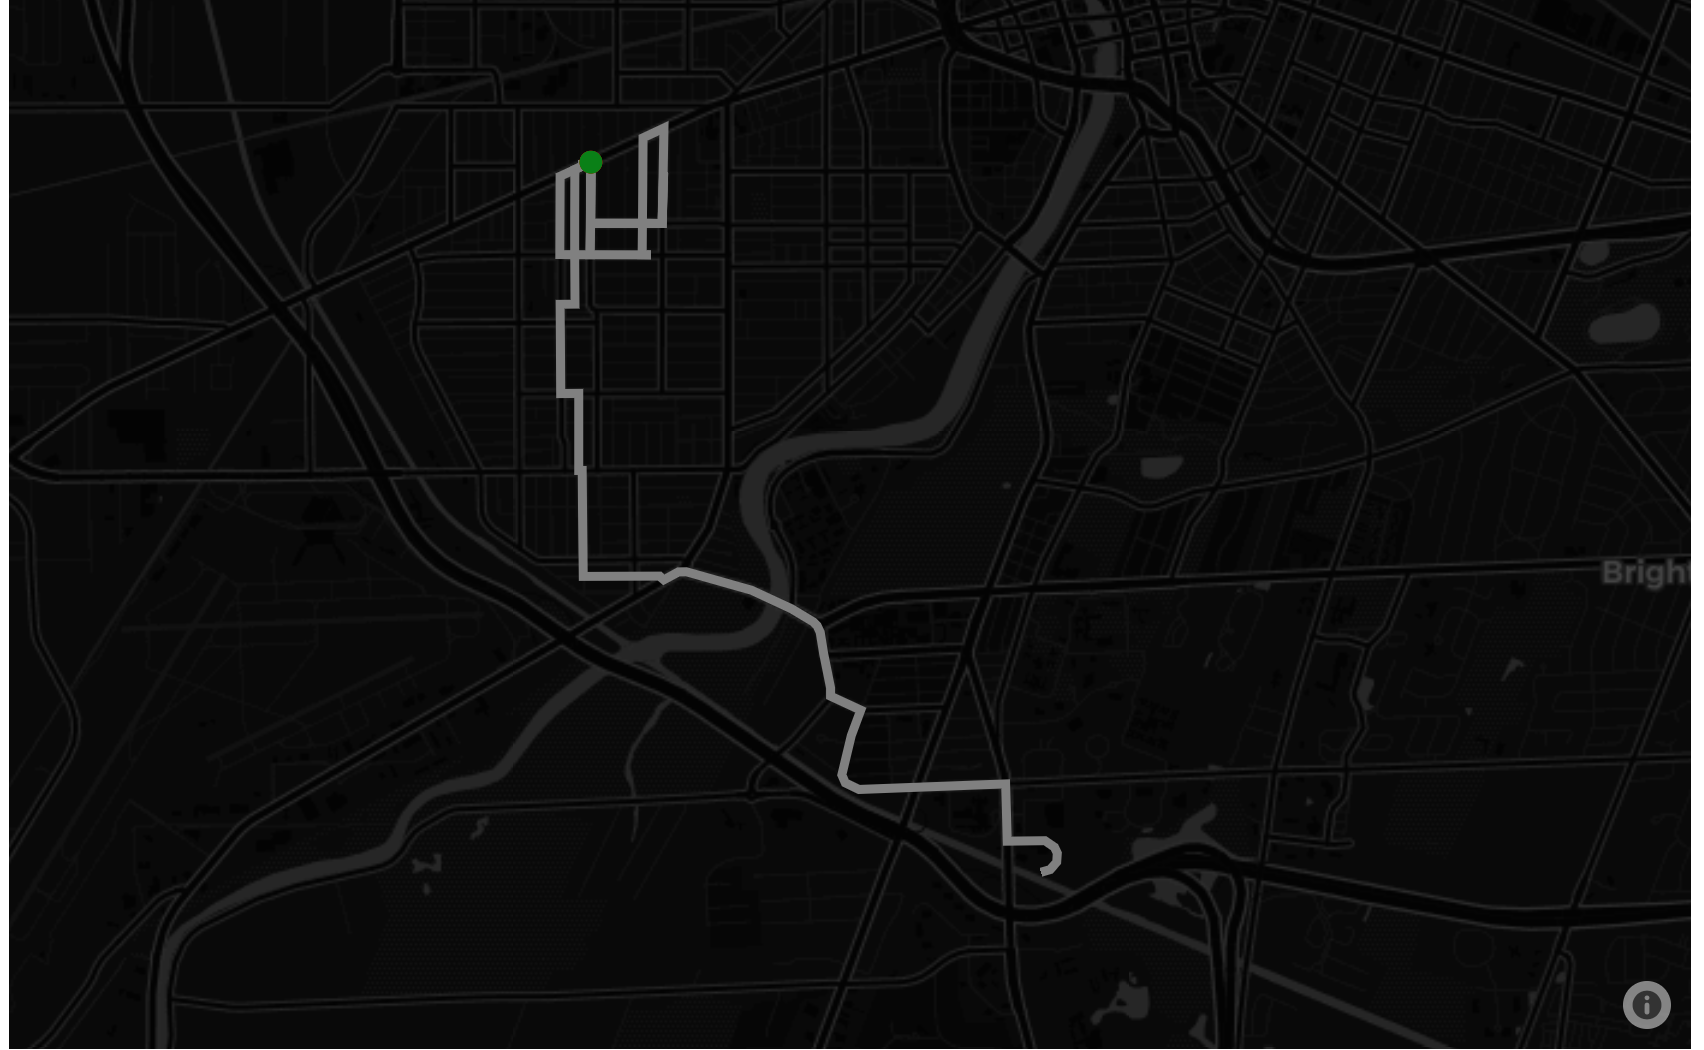

In [196]:
from IPython.display import Image
#Output for traversal of the path becasue the video is not visible on github. The purple circle 
#in the middle traverses the path from source to destination in a video form
Image(filename = "Closest Police Station.png", width = 700, height = 400)

In [92]:
mainroute[0] # Starting node
G.nodes[mainroute[0]].get('y')

43.1438765

In [93]:
G.nodes[mainroute[0]].get('x')

-77.6433538

In [94]:
r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{pst.loc[first.index(min(first))]["lon"]},{pst.loc[first.index(min(first))]["lat"]};{G.nodes[mainroute[0]].get('x')},{G.nodes[mainroute[0]].get('y')}?overview=false""")
   

In [106]:
nodes_to_pol_duration=json.loads(r.content)["routes"][0]["distance"]

In [107]:
total=sum(node_loc_duration)+sum(node_loc_duration2)+sum(node_loc_duration3)+nodes_to_pol_duration


In [108]:
total

3090.4000000000005

In [110]:
3090.40/60

51.50666666666667